## Final Project Submission

Please fill out:
* Student name: Benjamin Bai, Nicolas Pierce, Alvaro Mendizabal
* Student pace: Full Time
* Scheduled project review date/time: 8/5/2022
* Instructor name: David Elliott
* Blog post URL: (TBD)


# Intro

### Stakeholder, Business Questions
Stakeholder: Compass, Real Estate Agency

1. What features of a home best predict the price of the home?
2. What features positively or negatively impact a home's value?
3. What areas would be best to invest marketing resources, i.e. what areas have the most valuable homes that would yield the highest commissions for Compass' agents

### Data Dictionary: Column Names/Descriptions (King's County Home Data 2021-2022)
* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
* `greenbelt` - Whether the house is adjacent to a green belt
* `nuisance` - Whether the house has traffic noise or other recorded nuisances
* `view` - Quality of view from house
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
* `grade` - Overall grade of the house. Related to the construction and design of the house.
* `heat_source` - Heat source for the house
* `sewer_system` - Sewer system for the house
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `sqft_garage` - Square footage of garage space
* `sqft_patio` - Square footage of outdoor porch or deck space
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `address` - The street address
* `lat` - Latitude coordinate
* `long` - Longitude coordinate

# Data Cleaning
1. Duplicate/Null Handling
2. Data Exploration




3. 
4. Remove outliers (3+ standard devs from mean)
5. ID and handle multicollinearity
6. Select features for modeling
7. Normalize continuous data
8. OHE categorical data

In [1]:
# Imports
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import statsmodels.api as sm
from statsmodels.api import OLS
import seaborn as sns
plt.style.use('seaborn-notebook')
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder

# Remove warnings for readability
import warnings
warnings.filterwarnings("ignore")

### DataFrame

In [2]:
# Initialize dataframe from King's County House Data CSV; Parse Dates; View first 5 rows
kc_house = pd.read_csv('./data/kc_house_data_22.csv', parse_dates=['date'])
kc_house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


In [3]:
# See column names
kc_house.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long'],
      dtype='object')

In [4]:
# Check number rows/columns
kc_house.shape

(30155, 25)

30155 samples, 25 features

In [5]:
# See data types
kc_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             30155 non-null  int64         
 1   date           30155 non-null  datetime64[ns]
 2   price          30155 non-null  float64       
 3   bedrooms       30155 non-null  int64         
 4   bathrooms      30155 non-null  float64       
 5   sqft_living    30155 non-null  int64         
 6   sqft_lot       30155 non-null  int64         
 7   floors         30155 non-null  float64       
 8   waterfront     30155 non-null  object        
 9   greenbelt      30155 non-null  object        
 10  nuisance       30155 non-null  object        
 11  view           30155 non-null  object        
 12  condition      30155 non-null  object        
 13  grade          30155 non-null  object        
 14  heat_source    30123 non-null  object        
 15  sewer_system   3014

### Observations:
- 'view', 'condition', 'grade' need to be one hot encoded as categorical variables
- Need to extract 'zipcode' from address, and then 'zipcode' needs to be changed to a categorical variable

### Helper Functions
- __ohe__ used for setup of categorical data
- __scale_score__ used to standardize the scale of values in test/train data and score the standardized results to get more interpretable R-squared values
- __get_train_test_metrics__ used to calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RSME) for regression analysis

In [19]:
def ohe(df, df2, column):
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train, columns=col_labels, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, columns=col_labels, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
        
    return df, df2, encoded_train.columns.tolist()

In [20]:
def scale_score(x, y, x2, y2):
    scaler = StandardScaler()
    scaler.fit(x)
    X_train_scaled = scaler.transform(x)
    X_test_scaled = scaler.transform(x2)

    lr = LinearRegression()
    lr.fit(X_train_scaled,y_train)

    train_preds = lr.predict(X_train_scaled)
    test_preds = lr.predict(X_test_scaled)
    
    print(f"""training score: {r2_score(y_train, train_preds)}
    test score: {r2_score(y_test, test_preds)}""")
    
    return X_train_scaled, X_test_scaled, train_preds, test_preds

In [21]:
def get_train_test_metrics(y_train, train_preds,
               y_test, test_preds):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

### Initial Cleanup, Duplicate and Null Value Handling

In [6]:
# Check number of duplicate id's
kc_house['id'].duplicated().sum()

1

30154 out of 30155 ids are unique; need to drop 1 duplicate

In [7]:
# Drop duplicates
kc_house = kc_house.sort_values('id', ascending = False).drop_duplicates(subset = 'id', keep = 'first')

In [8]:
# Ensure that there are no longer duplicates
kc_house['id'].duplicated().sum()

0

In [9]:
# Recheck shape
kc_house.shape

(30154, 25)

In [10]:
# Drop 'id' - no longer useful as we have handled duplicate values
kc_house = kc_house.drop('id', axis=1)

In [11]:
# Check number of null values
kc_house.isnull().sum()

date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      32
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
dtype: int64

In [12]:
# Check out heat_source
print(kc_house['heat_source'].value_counts())

Gas                  20582
Electricity           6465
Oil                   2899
Gas/Solar               93
Electricity/Solar       59
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64


In [13]:
# Check out sewer_system
print(kc_house['sewer_system'].value_counts())

PUBLIC                25776
PRIVATE                4355
PRIVATE RESTRICTED        6
PUBLIC RESTRICTED         3
Name: sewer_system, dtype: int64


In [14]:
# Percent of sample that is null heat_source
((kc_house['heat_source'].isnull().sum()) / (len(kc_house)) * 100).round(2)

0.11

In [15]:
# Percent of sample that is null sewer_system
((kc_house['sewer_system'].isnull().sum()) / (len(kc_house)) * 100).round(2)

0.05

In [16]:
# Since the null values in heat_source and sewer_system comprise only 0.16% of the data, we will drop them
kc_house = kc_house.dropna()

In [17]:
# Final check for null values
kc_house.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
greenbelt        0
nuisance         0
view             0
condition        0
grade            0
heat_source      0
sewer_system     0
sqft_above       0
sqft_basement    0
sqft_garage      0
sqft_patio       0
yr_built         0
yr_renovated     0
address          0
lat              0
long             0
dtype: int64

# Data Exploration
Explore distributions of features, descriptive statistics, and visualizations for deeper understanding of the data

In [25]:
# Data Summary Statistics
kc_house.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,zipcode
count,3.011000e+04,30110.000000,30110.000000,30110.000000,3.011000e+04,30110.000000,30110.000000,30110.000000,30110.000000,30110.000000,30110.000000,30110.000000,30110.000000,30110.000000,30110.000000
mean,1.108921e+06,3.415211,2.335653,2113.296745,1.664907e+04,1.543491,1810.363766,476.586118,330.469678,217.448854,1975.160844,90.795782,47.328471,-121.318844,96718.452375
std,8.964895e+05,0.979769,0.888256,973.436623,5.993401e+04,0.567793,877.729415,579.790030,285.728094,245.305708,32.052466,416.204209,1.433331,5.724166,9126.043875
min,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,21.274240,-157.791480,1541.000000
25%,6.491180e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,1180.000000,0.000000,0.000000,40.000000,1953.000000,0.000000,47.405334,-122.326078,98030.000000
50%,8.600000e+05,3.000000,2.500000,1920.000000,7.476000e+03,1.500000,1560.000000,0.000000,400.000000,150.000000,1977.000000,0.000000,47.551437,-122.225815,98059.000000
75%,1.300000e+06,4.000000,3.000000,2620.000000,1.056800e+04,2.000000,2270.000000,940.000000,510.000000,320.000000,2003.000000,0.000000,47.669914,-122.116392,98117.000000
max,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,64.824070,-70.074340,99705.000000


### Data Observations

In [34]:
# Separate features into continuous vs. categorical; PairPlots of each to see relationship w/ 'price'
continuous = ['price','sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_garage','sqft_patio']
categorical = ['price', 'bedrooms','bathrooms','floors','waterfront','greenbelt','nuisance','view','condition','grade']

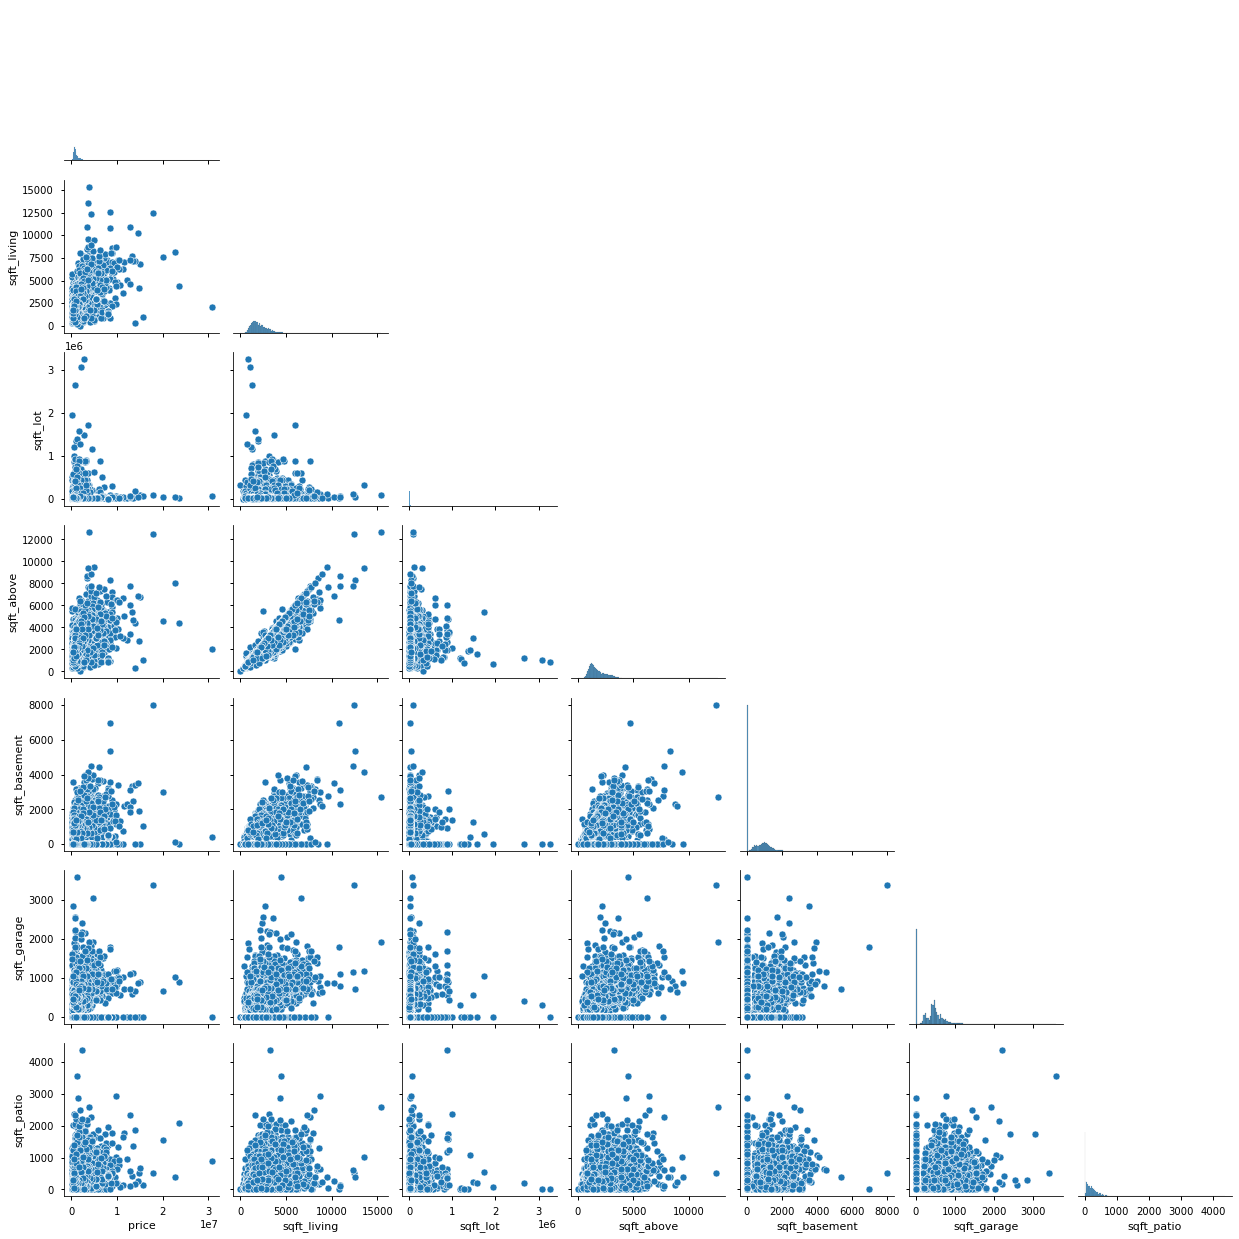

In [35]:
sns.pairplot(kc_house[continuous], diag_kind = 'hist', corner = True)

### Categorical Variables

In [ ]:
# 'view' categorization

In [ ]:
# condition categorization

In [ ]:
# grade categorization

In [ ]:
# zipcode categorization

In [ ]:
# Initialize zipcode list; extract zipcode from 'address' and add new column from list
zipcode = []
for zips in kc_house['address']:
    zipcode.append(int(zips[-20:-15]))

kc_house['zipcode'] = zipcode

# Drop address column and check dataframe
kc_house = kc_house.drop('address', axis=1)
kc_house.head()